In [22]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import tensorflow as tf
import keras

In [23]:
# Загрузка данных
data = pd.read_csv("./train.csv")

<Axes: xlabel='ClassId'>

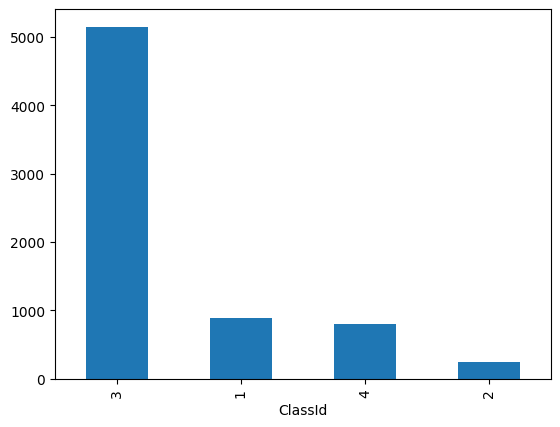

In [24]:
# Визуализация распределения классов
data["ClassId"].value_counts().plot(kind="bar")

In [38]:
# Подсчет количества изображений для каждого класса
class_counts = data["ClassId"].value_counts()
class_counts

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

In [25]:
# Подготовка данных для обучения модели
images = []
labels = []

for img, class_id, _ in tqdm(data.values):
    image = cv2.imread(f"./train_images/{img}", cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (120, 120))
    images.append(image)
    labels.append(class_id)

encoder = LabelEncoder()
X = np.array(images)
X = X / 255
y = encoder.fit_transform(labels)
y = to_categorical(y)

100%|██████████| 7095/7095 [00:30<00:00, 236.28it/s]


In [26]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

In [27]:
# Создание архитектуры нейронной сети
model = Sequential(
    [
        Conv2D(32, (3, 3), input_shape=(120, 120, 1), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(4, 4)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dense(4, activation="softmax"),
    ]
)

In [29]:
# Компиляция и обучение модели
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=["accuracy"])
history = model.fit(
    X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=128, verbose=1, callbacks=[early_stopping]
)

Epoch 1/15
45/45 [==============================] - 34s 736ms/step - loss: 0.8120 - accuracy: 0.7259 - val_loss: 0.8055 - val_accuracy: 0.7259
Epoch 2/15
45/45 [==============================] - 33s 737ms/step - loss: 0.7783 - accuracy: 0.7299 - val_loss: 0.7556 - val_accuracy: 0.7442
Epoch 3/15
45/45 [==============================] - 33s 724ms/step - loss: 0.7391 - accuracy: 0.7403 - val_loss: 0.7052 - val_accuracy: 0.7491
Epoch 4/15
45/45 [==============================] - 33s 728ms/step - loss: 0.6966 - accuracy: 0.7470 - val_loss: 0.6762 - val_accuracy: 0.7548
Epoch 5/15
45/45 [==============================] - 31s 692ms/step - loss: 0.6842 - accuracy: 0.7479 - val_loss: 0.6521 - val_accuracy: 0.7526
Epoch 6/15
45/45 [==============================] - 31s 686ms/step - loss: 0.6595 - accuracy: 0.7518 - val_loss: 0.6280 - val_accuracy: 0.7562
Epoch 7/15
45/45 [==============================] - 32s 711ms/step - loss: 0.6374 - accuracy: 0.7563 - val_loss: 0.6335 - val_accuracy: 0.7548

Увеличение количества эпох должно положительно сказаться на точности

In [30]:
# Функция для RLE-кодирования маски
def rle_encode(mask):
    rle_encoded_mask = []
    prev_value = mask[0][0]
    count = 1

    for value in mask[1:]:
        if value.any() != prev_value:
            rle_encoded_mask.append(int(prev_value))
            prev_value = value[0]
            count = 1
        else:
            count += 1

        rle_encoded_mask.append(int(prev_value))
    return " ".join(map(str, rle_encoded_mask))

In [34]:
# Подготовка тестовых данных и предсказание классов
test_images_dir = "./test_images/"
test_filenames = os.listdir(test_images_dir)
y_pred = []
encoded_pixels = []

In [41]:
# Предобработка и предсказание для тестовых изображений
with tqdm(total=len(test_filenames), position=0, leave=True) as pbar:
    for filename in test_filenames:
        image = cv2.imread(os.path.join(test_images_dir, filename), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (120, 120))
        _, mask = cv2.threshold(image, thresh=127, maxval=255, type=cv2.THRESH_BINARY)
        rle_encoded_mask = rle_encode(mask)
        encoded_pixels.append(rle_encoded_mask)
        prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)  # Установка verbose=0
        predicted_class = np.argmax(prediction, axis=1)[0] + 1
        y_pred.append(predicted_class)
        pbar.update()


100%|██████████| 5506/5506 [07:29<00:00, 12.26it/s]


In [ ]:
# Создание dataframe и сохранение в файл
submission_df = pd.DataFrame({"ImageId": test_filenames, "EncodedPixels": encoded_pixels, "ClassId": y_pred})
submission_df.to_csv("submission.csv", index=False, header=False)

Этот код представляет собой типичный процесс подготовки и обучения модели нейронной сети для классификации изображений. Вначале данные загружаются из CSV-файла, затем изображения обрабатываются (изменяют размер, нормализуются и т. д.), после чего происходит разделение данных на обучающую и тестовую выборки. Затем создается модель нейронной сети с несколькими сверточными слоями, слоями пулинга и полносвязными слоями. В конце добавляются оптимизатор и функция потерь для обучения модели. Результаты предсказаний сохраняются в файле submission.csv в формате, подходящем для отправки на платформу соревнования или дальнейшего анализа. В коде также присутствует функция для кодирования маски изображения в формате Run-Length Encoding (RLE) и визуализация распределения классов в обучающем наборе данных.  

RLE-кодирование (Run-Length Encoding) - это метод сжатия данных, который используется для кодирования последовательностей повторяющихся символов. В контексте компьютерного зрения, RLE-кодирование часто применяется для сжатия масок, которые представляют области изображения с определенными свойствами (например, области сегментации объектов).

Функция RLE-кодирования маски в данном контексте принимает на вход бинарную маску (матрицу из 0 и 1, где 1 обозначает область объекта), и кодирует ее в строку, содержащую информацию о последовательностях повторяющихся значений в маске. Это полезно, например, при подготовке результатов сегментации объектов для отправки на соревнования или анализа.

В коде выше, функция rle_encode принимает бинарную маску и возвращает строку, содержащую RLE-кодированное представление этой маски. Это используется для кодирования масок тестовых изображений, которые затем сохраняются вместе с предсказанными классами в файле submission.csv.